<a href="https://colab.research.google.com/github/sohyeon98720/doitDeeplearning/blob/master/doitDeeplearning_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 6강
# 다층신경망을 구현하기에 앞서 벡터의 개념과 np.sum -> np.dot의 개념 설명
import numpy as np
 
x = np.array([[1, 2],[3, 4]])
y = np.array([[5, 6],[7, 8]])
 
result = np.dot(x, y)
print(result)

[[19 22]
 [43 50]]


In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# 4,5강과 같은 데이터셋 사용
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer=load_breast_cancer()
x=cancer.data
y=cancer.target

In [4]:
print(x.shape)
print(y.shape)

(569, 30)
(569,)


In [0]:
x_train_all,x_test,y_train_all,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=42)

In [6]:
print(x_train_all.shape)
print(y_train_all.shape)

(455, 30)
(455,)


In [0]:
x_train,x_val,y_train,y_val=train_test_split(x_train_all,y_train_all,stratify=y_train_all,test_size=0.2,random_state=42)

In [8]:
print(x_train.shape)
print(y_train.shape)

(364, 30)
(364,)


In [9]:
print(x_train.shape,x_val.shape)

(364, 30) (91, 30)


In [0]:
# 벡터화연산을 적용한 뒤의 신경망모델. fit함수 주목.
class singleLayer_new:

  def __init__(self,learning_rate=0.1,l1=0,l2=0):
    self.w=None
    self.b=None
    self.losses=[]
    self.val_losses=[]
    self.w_history=[]
    self.lr=learning_rate
    self.l1=l1
    self.l2=l2

  def forpass(self,x):
    z=np.dot(x,self.w)+self.b
    return z

  def backprop(self,x,err):
    m=len(x)
    w_grad=np.dot(x.T,err)/m
    b_grad=np.sum(err)/m
    return w_grad,b_grad

  def activation(self,z):
    a=1/(1+np.exp(-z))
    return a

  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w))+self.l2/2*np.sum(self.w**2)

  def update_val_loss(self,x_val,y_val):
    z=self.forpass(x_val)
    a=self.activation(z)
    a=np.clip(a,1e-10,1-1e-10)
    val_loss=np.sum(-(y_val*np.log(a)+(1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss+self.reg_loss())/len(y_val))

  def fit(self,x,y,epochs=100,x_val=None,y_val=None):
    y=y.reshape(-1,1)
    y_val=y_val.reshape(-1,1)
    m=len(x)
    self.w=np.ones((x.shape[1],1))
    self.b=0
    self.w_history.append(self.w.copy())
    for i in range(epochs):
        z=self.forpass(x)
        a=self.activation(z)
        err=-(y-a)
        w_grad,b_grad=self.backprop(x,err)
        w_grad+=(self.l1 * np.sign(self.w) + self.l2 * self.w)/m
        self.w-=self.lr*w_grad
        self.b-=b_grad
        self.w_history.append(self.w.copy())
        a=np.clip(a,1e-10,1-1e-10)
        loss=np.sum(-(y*np.log(a)+(1-y)*np.log(1-a)))
        self.losses.append((loss+self.reg_loss())/m)
        self.update_val_loss(x_val,y_val)

  def predict(self,x):
    z=self.forpass(x)
    return z>0

  def score(self,x,y):
    return np.mean(self.predict(x)==y.reshape(-1,1))

In [11]:
print (y.shape)

(569,)


In [12]:
y22=y.reshape(-1,1)
print(y22.shape)

(569, 1)


In [0]:
# 5강 boxplot그래프에서 보았듯이 데이터의 범위가 다른데
# 이를 StandardScaler 모듈을 이용해 쉽게 전처리를 수행함.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(x_train)
x_train_scaled=scaler.transform(x_train)
x_val_scaled=scaler.transform(x_val)

In [15]:
single_layer=singleLayer_new(l2=0.01)
single_layer.fit(x_train_scaled,y_train,x_val=x_val_scaled,y_val=y_val,epochs=10000)
single_layer.score(x_val_scaled,y_val)

0.978021978021978

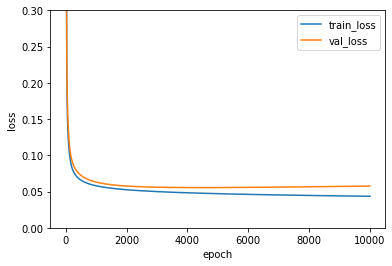

In [16]:
plt.ylim(0,0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()
# 그래프를 보고 배치 경사하강법의 특징을 알 수 있음

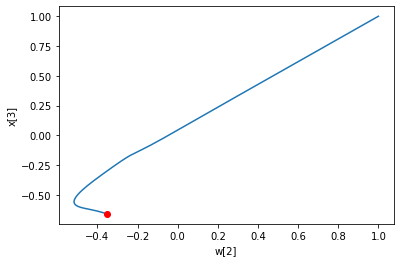

In [17]:
# 가중치의 변화를 살펴보기 위함
w2=[]
w3=[]
for w in single_layer.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2,w3)
plt.plot(w2[-1],w3[-1],'ro')
plt.xlabel('w[2]')
plt.ylabel('x[3]')
plt.show()

In [0]:
# 다층 신경망 구현
# 부모클래스 - singleLayer_new, 자식클래스 - DualLayer
# 수정된 부분이외의 함수(부모클래스로부터 물려받은 함수)를 생략하지 않은 이유는
# 이해하기 편리하게 하기 위함.
class DualLayer(singleLayer_new):

  def __init__(self,units=10,learning_rate=0.1,l1=0,l2=0):
    self.units=units
    self.w1=None
    self.b1=None
    self.w2=None
    self.b2=None
    self.a1=None
    self.losses=[]
    self.val_losses=[]
    self.lr=learning_rate
    self.l1=l1
    self.l2=l2

  def forpass(self,x):
    z1=np.dot(x,self.w1)+self.b1
    self.a1=self.activation(z1)
    z2=np.dot(self.a1,self.w2)+self.b2
    return z2

  def backprop(self,x,err):
    m=len(x)
    w2_grad=np.dot(self.a1.T,err)/m
    b2_grad=np.sum(err)/m
    err_to_hidden=np.dot(err,self.w2.T) * self.a1 * (1-self.a1)
    w1_grad=np.dot(x.T,err_to_hidden)/m
    b1_grad=np.sum(err_to_hidden,axis=0)/m
    return w1_grad,b1_grad,w2_grad,b2_grad

  def activation(self,z):
    a=1/(1+np.exp(-z))
    return a

  def init_weights(self,n_features):
    self.w1=np.ones((n_features,self.units))
    self.b1=np.zeros(self.units)
    self.w2=np.ones((self.units,1))
    self.b2=0

  def reg_loss(self):
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2/2*(np.sum(self.w1**2) + np.sum(self.w2**2))

  def update_val_loss(self,x_val,y_val):
    z=self.forpass(x_val)
    a=self.activation(z)
    a=np.clip(a,1e-10,1-1e-10)
    val_loss=np.sum(-(y_val*np.log(a)+(1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss+self.reg_loss())/len(y_val))

  def fit(self,x,y,epochs=100,x_val=None,y_val=None):
    y=y.reshape(-1,1)
    y_val=y_val.reshape(-1,1)
    m=len(x)
    self.init_weights(x.shape[1])
    for i in range(epochs):
        a=self.training(x,y,m)
        a=np.clip(a,1e-10,1-1e-10)
        loss=np.sum(-(y*np.log(a)+(1-y)*np.log(1-a)))
        self.losses.append((loss+self.reg_loss())/m)
        self.update_val_loss(x_val,y_val)


  def training(self,x,y,m):
    z=self.forpass(x)
    a=self.activation(z)
    err=-(y-a)
    w1_grad,b1_grad,w2_grad,b2_grad=self.backprop(x,err)
    w1_grad+=(self.l1 * np.sign(self.w1) + self.l2 * self.w1)/m
    w2_grad+=(self.l1 * np.sign(self.w2) + self.l2 * self.w2)/m
    self.w1-=self.lr * w1_grad
    self.b1-=self.lr * b1_grad
    self.w2-=self.lr * w2_grad
    self.b2-=self.lr * b2_grad
    return a

  def predict(self,x):
    z=self.forpass(x)
    return z>0

  def score(self,x,y):
    return np.mean(self.predict(x)==y.reshape(-1,1))

In [19]:
dual_layer=DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled,y_train,x_val=x_val_scaled,y_val=y_val,epochs=20000)
dual_layer.score(x_val_scaled,y_val)

0.978021978021978

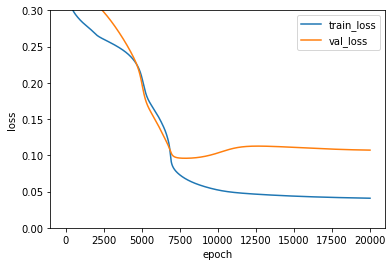

In [20]:
plt.ylim(0,0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

In [0]:
# 가중치 초기화를 개선한 모델.
# 부모클래스 - DualLayer , 자식클래스 - RandomInitNetwork
# 부모클래스의 모든 자원을 사용할 수 있는 상속의 특징이 있으므로
# 추가된 함수외에는 따로 써놓지 않음.
class RandomInitNetwork(DualLayer):

  def init_weights(self,n_features):
    np.random.seed(42)
    self.w1=np.random.normal(0,1,(n_features,self.units))
    self.b1=np.zeros(self.units)
    self.w2=np.random.normal(0,1,(self.units,1))
    self.b2=0


In [0]:
random_init_net=RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled,y_train,x_val=x_val_scaled,y_val=y_val,epochs=500)

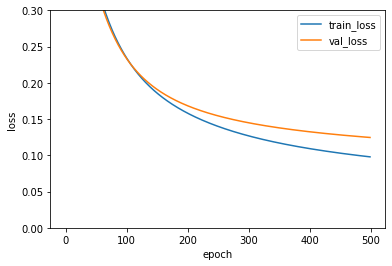

In [23]:
plt.ylim(0,0.3)
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()
# 가중치를 1로 설정한 것 보다(=DualLayer) 가중치를 랜덤초기화한(=RandomInitNetwork) 것이
# 더 빠르게 손실함수값이 줄어드는 것을 볼 수 있음.

In [0]:
# 미니배치 : 배치경사하강 + 확률적경사하강
class MinibatchNetwork(RandomInitNetwork):
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        super().__init__(units, learning_rate, l1, l2)
        self.batch_size = batch_size     # 배치 크기
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y_val = y_val.reshape(-1, 1)
        self.init_weights(x.shape[1])
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            for x_batch, y_batch in self.gen_batch(x, y):
                y_batch = y_batch.reshape(-1, 1)
                m = len(x_batch)
                a = self.training(x_batch, y_batch, m)
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / len(x))
            self.update_val_loss(x_val, y_val)

    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1 
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]

In [25]:
minibatch_net=MinibatchNetwork(l2=0.01,batch_size=32)
minibatch_net.fit(x_train_scaled,y_train,x_val=x_val_scaled,y_val=y_val,epochs=500)
minibatch_net.score(x_val_scaled,y_val)

0.978021978021978

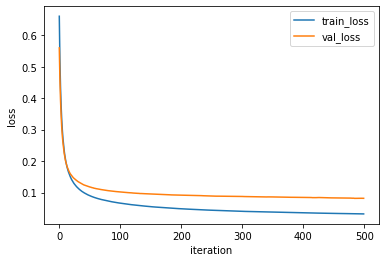

In [26]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss','val_loss'])
plt.show()

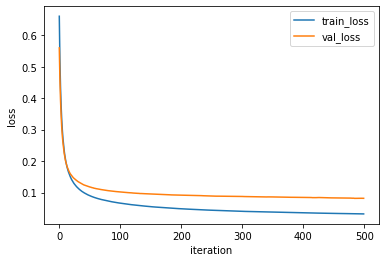

In [27]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss','val_loss'])
plt.show()

In [28]:
# 배치사이즈를 늘림(32 -> 128)
minibatch_net2=MinibatchNetwork(l2=0.01,batch_size=128)
minibatch_net2.fit(x_train_scaled,y_train,x_val=x_val_scaled,y_val=y_val,epochs=500)
minibatch_net2.score(x_val_scaled,y_val)

0.978021978021978

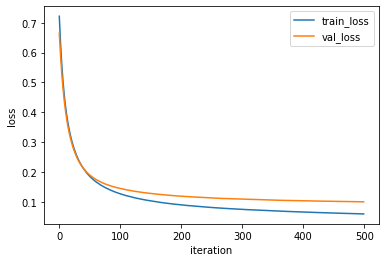

In [29]:
plt.plot(minibatch_net2.losses)
plt.plot(minibatch_net2.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss','val_loss'])
plt.show()

In [0]:
# 사이킷런 모듈을 이용한 다층신경망 구현
from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier(hidden_layer_sizes=(10,),activation='logistic',
                  solver='sgd',alpha=0.01,batch_size=32,learning_rate_init=0.1,max_iter=500)

In [31]:
mlp.fit(x_train_scaled,y_train)
mlp.score(x_val_scaled,y_val)

0.989010989010989